<a href="https://colab.research.google.com/github/mrjoness/LSS_BBA/blob/main/BBA_LSS_collab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSS applied to CA-backbone of BBA fast-folding protein


In [1]:
import torch

In [2]:
if torch.cuda.is_available():
  print('GPU available')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

GPU available


In [3]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

##Uploading files

Navigate to Uploads directory and select all:


(i) 1FME-0-c-alpha.pdb

(ii) 1FME-0-c-alpha-000.dcd

(iii) model_snrv-3.pth

(iv) model_mdn-100.pth

(v) model_ddpm-25.pth


N.B. If file upload fails, try using alternate upload means by clicking on file icon in left menu and directly uploading to colab session storage or by uploading to and mounting Google Drive

In [4]:
# this is going to take too long, just upload the first dcd and the
# takes 45 minutes to upload 7 files
#

from google.colab import files
files.upload()

Saving model_ddpm-25.pth to model_ddpm-25.pth
Saving model_mdn-100.pth to model_mdn-100.pth
Saving model_snrv-3.pth to model_snrv-3.pth


In [7]:
# upload pre-trained models -- this takes about 5 minutes
# just make one folder with everything that needs to be uploaded

from google.colab import files
files.upload()

Saving 1FME-0-c-alpha.pdb to 1FME-0-c-alpha.pdb
Saving 1FME-0-c-alpha-000.dcd to 1FME-0-c-alpha-000.dcd


In [ ]:
%pip install numpy scipy pandas scikit-learn jupyter ipywidgets==7.7.2 widgetsnbextension jupyter_contrib_nbextensions matplotlib MDTraj tqdm pytest pyemma deeptime einops torch torchvision pytorch-lightning nglview

In [8]:
# enable jupyter extensions

!jupyter nbextension enable --py --sys-prefix widgetsnbextension
!jupyter nbextension enable nglview --py --sys-prefix
!nglview enable

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Enabling notebook extension nglview-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Enabling notebook extension nglview-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/usr/etc/jupyter/nbconfig/notebook.json


In [9]:
# install each LSS component

%pip install git+https://github.com/andrewlferguson/snrv.git
%pip install git+https://github.com/Ferg-Lab/mdn_propagator.git
%pip install git+https://github.com/Ferg-Lab/molgen.git

  Cloning https://github.com/andrewlferguson/snrv.git to /tmp/pip-req-build-xfi0chj6
  Running command git clone --filter=blob:none --quiet https://github.com/andrewlferguson/snrv.git /tmp/pip-req-build-xfi0chj6
  Resolved https://github.com/andrewlferguson/snrv.git to commit 63aeebc2f0253bec9f5e0ab03615c107256bf34f
  Preparing metadata (setup.py) ... done
  Created wheel for snrv: filename=snrv-0.1.0+52.g63aeebc-py3-none-any.whl size=30278 sha256=cc292d12e15cd1b6dc1d77acb0969a2ae9ba3cecd98875890da5a8796be1bba3
  Stored in directory: /tmp/pip-ephem-wheel-cache-xe1sft22/wheels/d8/83/c6/26e7926d23676778257c4238a0e7ca498b668f07b425672242
Successfully built snrv
  Cloning https://github.com/Ferg-Lab/mdn_propagator.git to /tmp/pip-req-build-o0mj0sil
  Running command git clone --filter=blob:none --quiet https://github.com/Ferg-Lab/mdn_propagator.git /tmp/pip-req-build-o0mj0sil
  Resolved https://github.com/Ferg-Lab/mdn_propagator.git to commit ad8fd32faf84908b2c4f58bf7e16195a7c4f29e8
  Inst

Load the different components from their respective repos

In [26]:
from mdn_propagator.propagator import Propagator
from molgen.models import DDPM
from snrv import Snrv
from snrv.utils import set_random_seed

In [12]:
import mdtraj as md
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import glob
import nglview as nv

import seaborn as sns
from scipy.stats import pearsonr

# Load 1/10 DESRES trajectories used for training

In [14]:
# only load one dcd to save time

#load_path = '/project/andrewferguson/DESRES/DESRES-Trajectory_1FME-0-c-alpha/1FME-0-c-alpha'
load_path = './'

trj_fnames = sorted(glob.glob(f'{load_path}/1FME-0-c-alpha-00*.dcd'))
top_fname = f'{load_path}/1FME-0-c-alpha.pdb'
save_freq = 200 # ps

print(trj_fnames)

['./1FME-0-c-alpha-000.dcd']


In [20]:

trjs = [md.load(t, top=top_fname).center_coordinates() for t in trj_fnames]
print(len(trjs), trjs[0].xyz.shape)

1 (100000, 28, 3)


In [21]:
from google.colab import output
output.enable_custom_widget_manager()

In [19]:
# view an example trj

v = nv.show_mdtraj(trjs[0])
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=99999)

In [22]:
# extract all distances between CA as features -- 28 residues == 378 featurse

coords_torch = list()
for trj in trjs:
    pdists = [torch.pdist(p)[None] for p in torch.tensor(trj.xyz)]
    coords_torch.append(torch.cat(pdists))
len(coords_torch), coords_torch[0].shape

(1, torch.Size([100000, 378]))

In [23]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# SRV fitting

In [25]:
set_random_seed(42)

Setting random seed to 42


In [28]:
# train for 3 epochs (1_000_000 frames each) to avoid overfitting

input_size = coords_torch[0].size()[1]
output_size = 7
hidden_depth = 2
hidden_size = 100
batch_norm = True
dropout_rate = 0.0
lr = 1E-2
weight_decay = 0.0
val_frac = 0.05
n_epochs = 3
batch_size = 25000
VAMPdegree = 2
is_reversible = True
num_workers = 0

model_snrv = Snrv(input_size, output_size, hidden_depth=hidden_depth, hidden_size=hidden_size,
            batch_norm=batch_norm, dropout_rate=dropout_rate, lr=lr, weight_decay=weight_decay,
            val_frac=val_frac, n_epochs=n_epochs, batch_size=batch_size,
            VAMPdegree=VAMPdegree,is_reversible=is_reversible, num_workers=num_workers,
            activation=torch.nn.GELU(), device=device)

model_snrv = model_snrv.to(device)

In [31]:
# load pretrained SRV model

# (10 ns lag)  selected based on previous hyperparam check
lag_n = 50

load_pretrained_snrv = True
save_new_model = False
model_save_path = './model_snrv-3.pth'

if load_pretrained_snrv:
    ckp = torch.load(model_save_path)
    model_snrv.load_state_dict(ckp['model_state_dict'])
    model_snrv.training_losses = ckp['training_losses']
    model_snrv.validation_losses = ckp['validation_losses']
    model_snrv.evals = ckp['evals']
    model_snrv.expansion_coefficients = ckp['expansion_coefficients']
    model_snrv.is_fitted = True

else:
    model_snrv.fit(coords_torch, lag=lag_n, scheduler=0.98)
    if save_new_model:
        torch.save(model_snrv.state_dict(), model_save_path)

        torch.save({
        'model_state_dict': model_snrv.state_dict(),
        'training_losses': model_snrv.training_losses,
        'validation_losses': model_snrv.validation_losses,
        'evals': model_snrv.evals,
        'expansion_coefficients': model_snrv.expansion_coefficients,
        }, model_save_path)

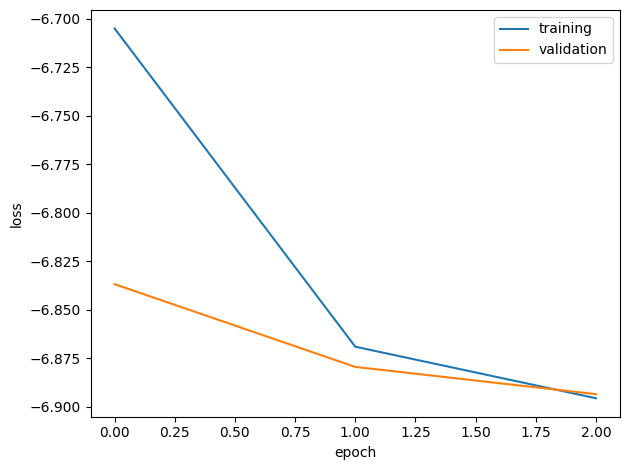

In [32]:
# after 5 epochs, training di

fig, ax = plt.subplots()
ax.plot(np.arange(len(model_snrv.training_losses)), model_snrv.training_losses)
ax.plot(np.arange(len(model_snrv.validation_losses)), model_snrv.validation_losses)
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend(['training','validation'])
fig.tight_layout()

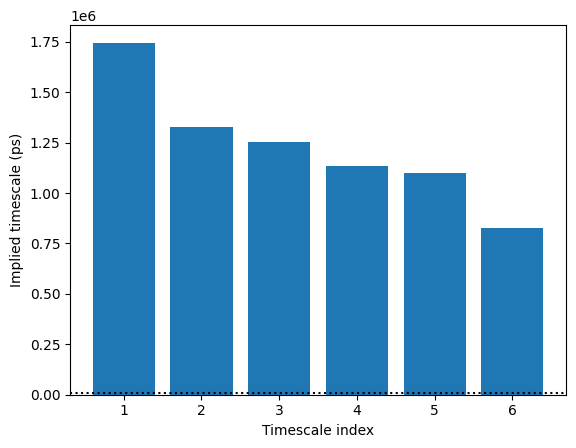

In [33]:
evals = model_snrv.evals.cpu().detach().numpy()
plt.bar(range(1, evals.size), -lag_n*save_freq/np.log(evals[1:]))  # by default use evals[1:]
plt.ylabel('Implied timescale (ps)')
plt.xticks(range(1, evals.size))
plt.xlabel('Timescale index')
plt.axhline(lag_n*save_freq, color='k', linestyle=':')

In [35]:
evecs = model_snrv.transform(torch.cat(coords_torch)).cpu().detach().numpy()
print(evecs.shape)

(100000, 7)


In [36]:
import deeptime as dt
tica = dt.decomposition.TICA(lagtime=5, dim=2)
TICs = tica.fit_transform([a.numpy() for a in coords_torch]).reshape(-1, 2)

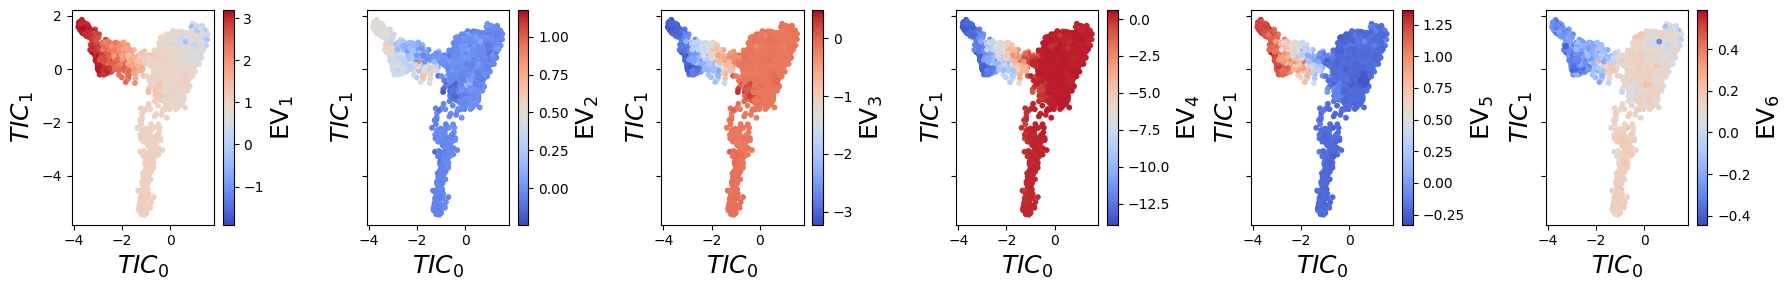

In [37]:
fig, axes = plt.subplots(1, 6, figsize = (18, 3), sharey=True, sharex=True)
axes = axes.flatten()
stride = 10

for e in range(1, evecs.shape[1]):
    evec = evecs[::stride, e]
    ax = axes[e-1]

    im = ax.scatter(TICs[::stride, 0], TICs[::stride, 1], c=evec, s=10, cmap='coolwarm')
    ax.set_xlabel('$TIC_0$', fontsize=18)
    ax.set_ylabel('$TIC_1$', fontsize=18)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label(f'EV$_{e}$', size=18)

plt.tight_layout()

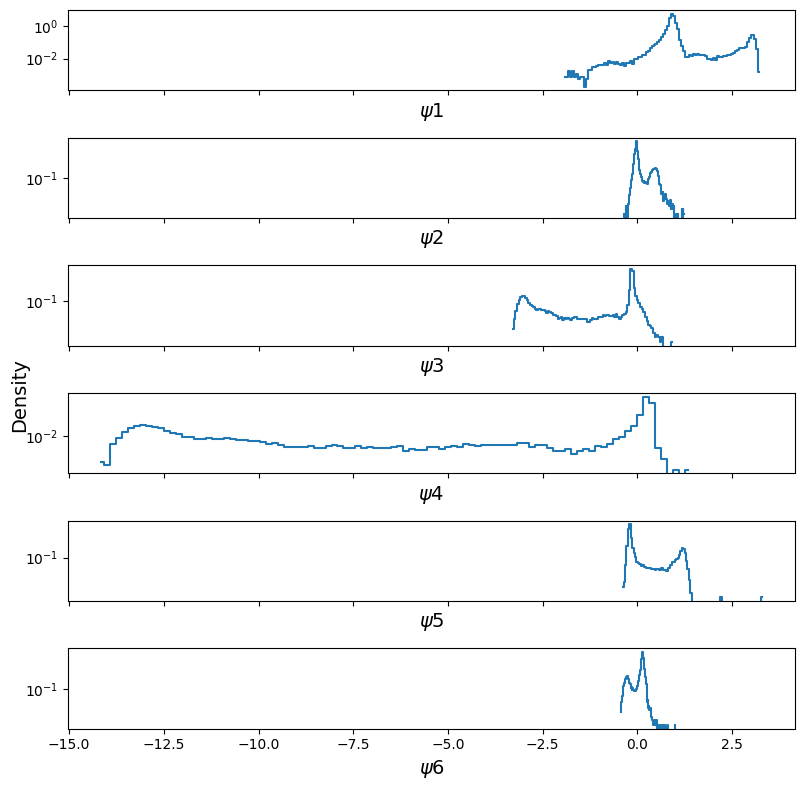

In [38]:
# check where transitions show up over trajectories

evec_idx = 4
nbins = 100
ntrjs = 10

fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

for evec_idx, ax in enumerate(axes):
    bins = np.linspace(np.min(evecs[:, evec_idx+1]), np.max(evecs[:, evec_idx+1]), nbins)
    counts, bin_edges = np.histogram(evecs[:, evec_idx+1], bins=bins, density=True)

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    free_energy = -np.log(counts + 1e-10)

    #ax.plot(bin_centers, free_energy, drawstyle='steps-mid')
    ax.plot(bin_centers, counts, drawstyle='steps-mid')
    ax.set_xlabel(f'$\psi{evec_idx+1}$', fontsize=14)
    ax.set_yscale('log')

fig.text(0.0, 0.5, 'Density', va='center', rotation='vertical', fontsize=14)
plt.tight_layout()


Text(145.72222222222223, 0.5, 'Residue index')

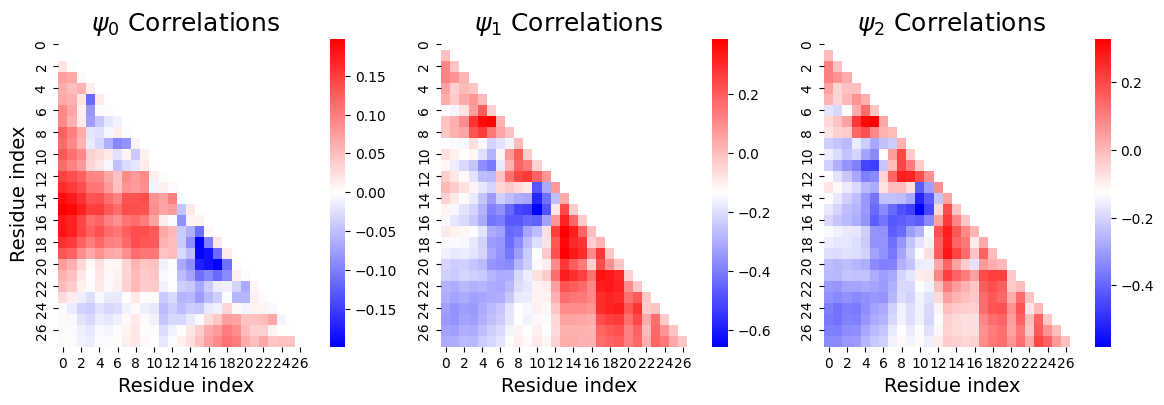

In [39]:
# Interpret modesl by checking correlations against input features (pairwise distances)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

all_feats = np.concatenate(coords_torch)
num_features = all_feats.shape[1]
nres = trjs[0].n_residues

for evec_idx, ax in enumerate(axes):

    heatmap = np.zeros((nres, nres))
    correlations = np.zeros(num_features)
    cnt = 0

    for i in range(num_features):
        correlations[i], _ = pearsonr(all_feats[:, i], evecs[:, evec_idx])

    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap[i, j] = correlations[cnt]
            heatmap[j, i] = correlations[cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap, dtype=bool))
    sns.heatmap(heatmap, mask=mask, cmap='bwr', ax=ax)

    ax.set_title(f'$\psi_{evec_idx}$ Correlations', fontsize=18)
    ax.set_xlabel('Residue index', fontsize=14)

axes[0].set_ylabel('Residue index', fontsize=14)


In [ ]:
# can remove these

def find_longest_consecutive_sequence(arr):

    if len(arr) == 0:
        return []

    # Initialize variables
    longest_streak = []
    current_streak = [arr[0]]

    # Iterate through the array
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_streak.append(arr[i])
        else:
            if len(current_streak) > len(longest_streak):
                longest_streak = current_streak
            current_streak = [arr[i]]

    # Final check for the longest streak at the end of the array
    if len(current_streak) > len(longest_streak):
        longest_streak = current_streak

    return longest_streak

def find_all_consecutive_sequence_ranges(arr):
    if len(arr) == 0:
        return []

    # Initialize variables
    streaks = []
    current_streak_start = arr[0]
    current_streak_end = arr[0]

    # Iterate through the array
    for i in range(1, len(arr)):
        if arr[i] == arr[i - 1] + 1:
            current_streak_end = arr[i]
        else:
            streaks.append((current_streak_start, current_streak_end))
            current_streak_start = arr[i]
            current_streak_end = arr[i]

    # Add the last streak to the list
    streaks.append((current_streak_start, current_streak_end))

    # Sort the streaks by length from longest to shortest
    streaks.sort(key=lambda x: x[1] - x[0], reverse=True)

    return streaks

Text(0.08, 0.5, 'Residue Index')

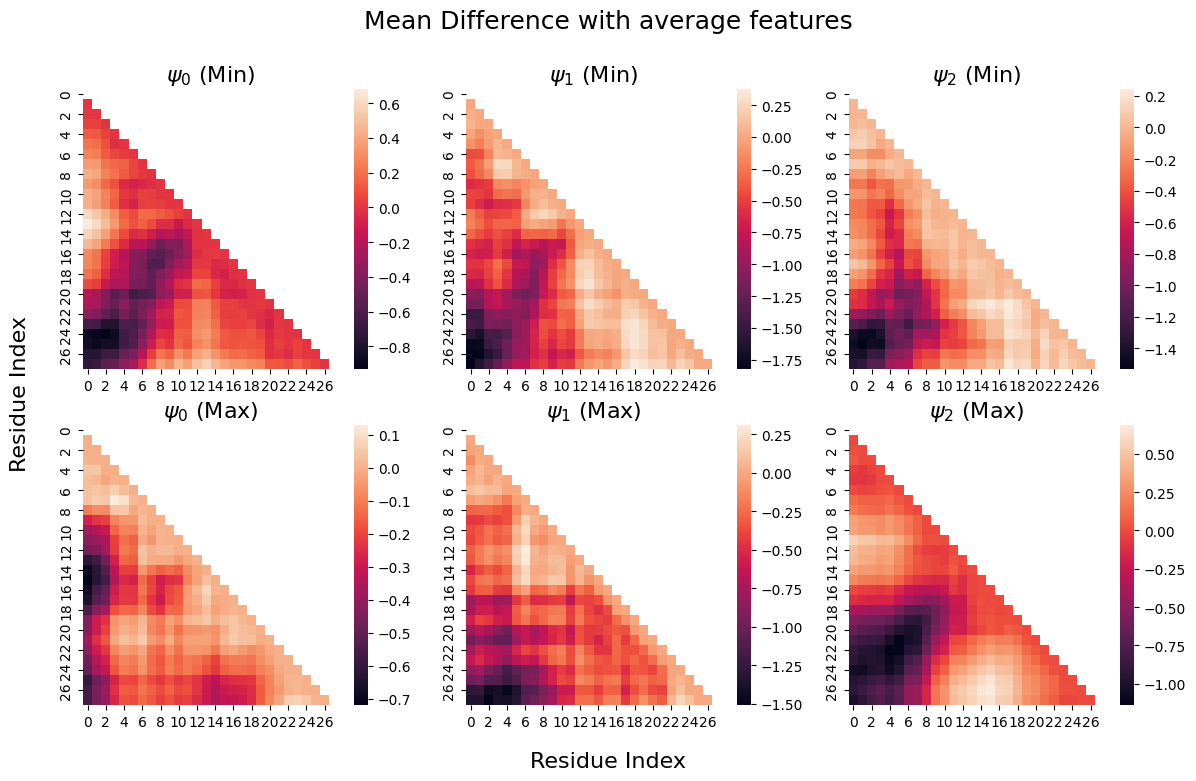

In [48]:
# identify and visualize different metastable states
# average over the 1000 highest and lowest values that eahc thetevenc

fig, axes = plt.subplots(2, 3, figsize=(14, 8))
max_frames = 100  # 1000

for evec_idx, ax_row in enumerate(axes.T):

    evec_mins = np.argsort(evecs[:, evec_idx])[-max_frames:]
    evec_maxs = np.argsort(evecs[:, evec_idx])[:max_frames]
    ref_means = np.mean(all_feats, axis=0)

    heatmap_mins = np.zeros((nres, nres))
    heatmap_maxs = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap_mins[j, i] = np.mean(all_feats[evec_mins, cnt]) - ref_means[cnt]
            heatmap_maxs[j, i] = np.mean(all_feats[evec_maxs, cnt]) - ref_means[cnt]
            cnt += 1

    mask = np.triu(np.ones_like(heatmap_mins, dtype=bool))
    sns.heatmap(heatmap_mins, mask=mask, ax=ax_row[0])
    sns.heatmap(heatmap_maxs, mask=mask, ax=ax_row[1])

    ax_row[0].set_title(f'$\psi_{evec_idx}$ (Min)', fontsize=16)
    ax_row[1].set_title(f'$\psi_{evec_idx}$ (Max)', fontsize=16)

fig.suptitle('Mean Difference with average features', fontsize=18)
fig.text(0.5, 0.04, 'Residue Index', ha='center', va='center', fontsize=16)
fig.text(0.08, 0.5, 'Residue Index', ha='center', va='center', rotation='vertical', fontsize=16)


In [49]:
# convert to thet

CVs = [model_snrv.transform(x).cpu().detach()[:, 1:] for x in coords_torch]
CVs[0].shape, len(CVs)

(torch.Size([100000, 6]), 1)

# MDN propagator

In [42]:
model_mdn = Propagator(dim = CVs[0].size(1))

In [43]:
lag_mdn = 50   # set to same as SRV for now but this does not need to be the case

load_pretrained_mdn = True
save_new_model = False
model_save_path = './model_mdn-100.pth'

if load_pretrained_mdn:
    model_mdn.load_state_dict(torch.load(model_save_path))
    model_mdn.is_fit = True

else:
    model_mdn.fit(CVs, lag = 10, max_epochs=100)
    if save_new_model:
        torch.save(model_mdn.state_dict(), model_save_path)


In [44]:
# generate 10x longer synthetic traj

n_steps = 10 * len(evecs) / lag_n
x = CVs[0][0][None]
synthetic_traj_CVs = model_mdn.gen_synthetic_traj(x, n_steps)
synthetic_traj_CVs.shape

  0%|          | 0/20000 [00:00<?, ?it/s]

torch.Size([20000, 6])

Text(0.5, 0, 'N lag times (10 ns)')

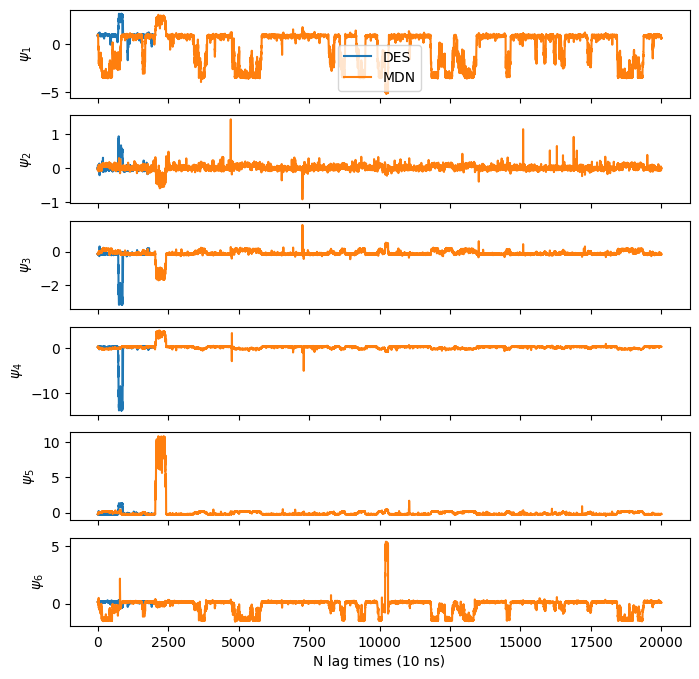

In [46]:
fig, axes = plt.subplots(6, figsize=(8, 8), sharex=True)

for evec_idx, ax in enumerate(axes):
    ax.plot(evecs[::lag_n, evec_idx+1], label='DES')
    ax.plot(synthetic_traj_CVs[:, evec_idx], label='MDN')
    ax.set_ylabel(f'$\psi_{evec_idx+1}$')

axes[0].legend()
axes[-1].set_xlabel('N lag times (10 ns)')

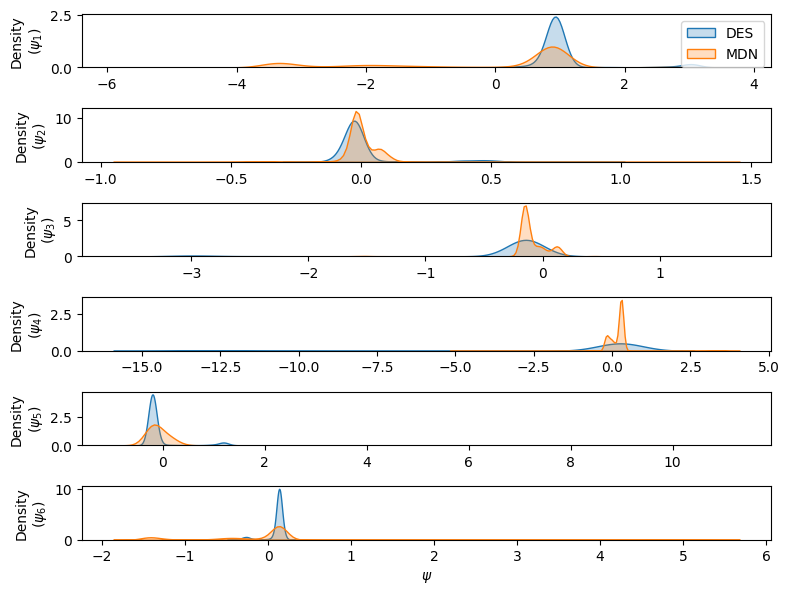

In [47]:
# histograms of all evecs across time -- ensures thermodynamics are approximately reproduced

fig, axes = plt.subplots(6, figsize=(8, 6), sharex=False)

evecs = np.array(evecs)
synthetic_traj_CVs = np.array(synthetic_traj_CVs)
evecs[np.isinf(evecs)] = np.nan
synthetic_traj_CVs[np.isinf(synthetic_traj_CVs)] = np.nan

for evec_idx, ax in enumerate(axes):
    sns.kdeplot(evecs[::lag_n, evec_idx+1], ax=ax, label='DES', fill=True)
    sns.kdeplot(synthetic_traj_CVs[:, evec_idx], ax=ax, label='MDN', fill=True)
    ax.set_ylabel(f'Density\n($\psi_{evec_idx+1}$)')

axes[0].legend()
axes[-1].set_xlabel('$\psi$')

plt.tight_layout()
plt.show()


# DDPM Decoder

In [50]:
# flatten coordiantes before passing to DDPM

n = trjs[0].xyz.shape[0]
xyz = [torch.tensor(trj.xyz.reshape(n, -1)).float() for trj in trjs]

print(xyz[0].shape)

torch.Size([100000, 84])


In [51]:
# uses 1000 steps by default, but 50-100 will be much faster and should work fine

model_ddpm = DDPM(xyz[0].shape[1], CVs[0].shape[1])

In [54]:
%time

load_pretrained_ddpm = True
save_new_model = False
model_save_path = './model_ddpm-25.pth'

if load_pretrained_ddpm:
    model_ddpm.load_state_dict(torch.load(model_save_path))
    model_ddpm.is_fit = True

else:
    model_ddpm.fit(xyz, CVs, max_epochs=25)
    if save_new_model:
        torch.save(model_ddpm.state_dict(), model_save_path)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [55]:
synthetic_traj_CVs.shape

(20000, 6)

In [ ]:
# Decode a set of real SRV coordinates first and check adherence to conditioning

# each xyz idx should correspond to trj idx
trj_ref = md.join([trj[0] for trj in trjs])
evecs_ref = evecs[::100_000, 1:]

xyz_gen = model_ddpm.generate(torch.Tensor(evecs_ref))
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)
fake_trj = md.join([ft.superpose(rf) for ft, rf in zip(fake_trj, trj_ref)])

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [ ]:
v = nv.show_mdtraj(trj_ref)
v.add_trajectory(fake_trj)

v[0].clear_representations()
v[0].add_representation('ball+stick', color='blue')

v[1].clear_representations()
v[1].add_representation('ball+stick', color='red')
v

In [ ]:
# calculate pairwise distances between each ref and gen structure
# we should observe similar profiles between the top row and bottom row plots

pdists_ref = [torch.pdist(p)[None] for p in torch.tensor(trj_ref.xyz)]
pdists_gen = [torch.pdist(p)[None] for p in torch.tensor(fake_trj.xyz)]

fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for f, (p_ref, p_gen, ax_row) in enumerate(zip(pdists_ref, pdists_gen, axes.T)):

    heatmap_ref = np.zeros((nres, nres))
    heatmap_gen = np.zeros((nres, nres))

    cnt = 0
    for i in range(len(heatmap)):
        for j in range(i+1, nres):
            heatmap_ref[j, i] = p_ref[0, cnt].numpy()
            heatmap_gen[j, i] = p_gen[0, cnt].numpy()
            cnt += 1

    mask = np.triu(np.ones_like(heatmap_ref, dtype=bool))
    sns.heatmap(heatmap_ref, mask=mask, cmap='Reds', ax=ax_row[0], cbar=False)
    sns.heatmap(heatmap_gen, mask=mask, cmap='Reds', ax=ax_row[1], cbar=False)
    ax_row[0].set_title(f'Frame {f*100_000}')

for ax in axes.flatten():
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axes[0, 0].set_ylabel('Real Traj')
axes[0, 1].set_ylabel('Fake Traj')


# Decode synthetic traj

In [ ]:
xyz_gen = model_ddpm.generate(torch.Tensor(synthetic_traj_CVs[:20]))

In [ ]:
xyz_gen = xyz_gen.reshape(xyz_gen.size(0), -1 , 3).numpy()
fake_trj = md.Trajectory(xyz = xyz_gen, topology=trjs[0].top)

In [ ]:
# decode first frame of each traj (each has different embeddings)

xyz_ref = [trj.xyz for trj in trjs]
evec_ref = evecs[:10]

# Visualize results

In [ ]:
import nglview as nv

In [ ]:
v = nv.show_mdtraj(fake_trj)
v.clear_representations()
v.add_representation('ball+stick')
v

NGLWidget(max_frame=19)